In [3]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

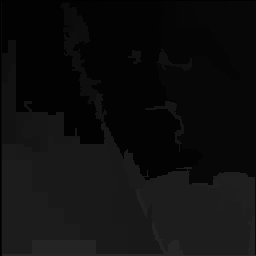

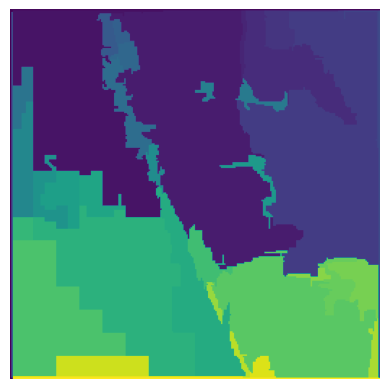

In [6]:
# Load the image
image = cv2.imread('/content/1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to obtain a binary image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological operations to enhance the image
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Perform the distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
dist_transform = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Apply the watershed transform
_, sure_bg = cv2.threshold(dist_transform, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply the watershed algorithm
markers = cv2.watershed(image, markers)
image[markers == -1] = [0, 0, 255]

# Apply the lattice-cut algorithm
segmentation = cv2.ximgproc.segmentation.createGraphSegmentation()
segmentation.setSigma(0.5)
result = segmentation.processImage(image)

# Display and save the segmentation result
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(result)
plt.axis('off')
plt.savefig('segmentation_result.png', bbox_inches='tight', pad_inches=0)


In [8]:
pip install -U scikit-fuzzy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894073 sha256=8ff47be7a9121e0d8b8d17b92d90edeeae29cf8b363b9d286ffb3948dd9282e3
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [9]:
import skfuzzy as fuzz

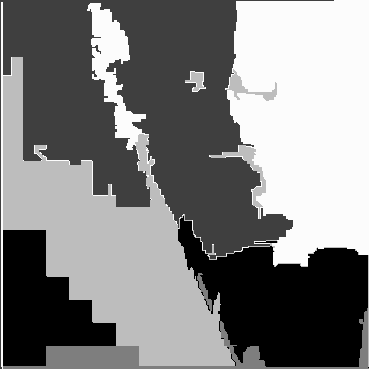

In [12]:
# Load the segmentation result
segmentation_result = cv2.imread('segmentation_result.png')
segmentation_result = cv2.cvtColor(segmentation_result, cv2.COLOR_BGR2RGB)
segmentation_result = segmentation_result.astype(np.float32) / 255.0

# Reshape the image into a 2D array
rows, cols, _ = segmentation_result.shape
data = segmentation_result.reshape((rows * cols, 3))

# Perform FCM clustering
num_clusters = 5
fuzziness = 2.0
max_iterations = 100
error_tolerance = 0.01

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data.T, num_clusters, fuzziness, error_tolerance, max_iterations, seed=0
)

# Get the cluster labels
cluster_labels = np.argmax(u, axis=0)

# Reshape the cluster labels into the original image shape
cluster_labels = cluster_labels.reshape((rows, cols))

# Display the clustering result
cv2_imshow( cluster_labels.astype(np.uint8) * int(255 / (num_clusters - 1)))
cv2.waitKey(0)
cv2.destroyAllWindows()
